In [1]:
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow_probability as tfp

import sys
sys.path.append('/Users/jay/Desktop/Bachelorarbeit/Implementation')
from dependencies.hbv_sask.model import HBVSASKModel as hbvmodel
from dependencies.PyDREAM.pydream.parameters import SampledParam



TIME_COLUMN_NAME = 'TimeStamp'
INDEX_COLUMN_NAME = "Index_run"
PLOT_FORCING_DATA = True
PLOT_ALL_THE_RUNS = True
QOI_COLUMN_NAME = "model"  # "Value"
MODEL = 'hbv-sask'  #'hbv-sask' # 'banchmark_model' or 'simple_model' or 'hbv-sask'
QOI_COLUMN_NAME = "Q_cms"
QOI_COLUM_NAME_MESURED = "streamflow"

ndims = 7
dims = ['TT', 'C0', 'beta', 'ETF', 'FC', 'FRAC', 'K2']
colors = sns.color_palette(n_colors=ndims)

# Measured Data (TODO: measure data)
measured_data = np.array([9.50, 9.18, 8.85, 7.78, 7.01, 7.53, 7.31, 6.76, 6.60, 7.07, 9.94, 10.70, 9.58, 8.53, 8.86, 8.73, 10.10, 9.72, 10.30, 10.50, 10.30, 9.99, 9.65, 10.10, 10.30, 12.50, 15.10, 16.30, 17.00, 22.80, 27.00, 26.20])


In [2]:
# Defining paths and Creating Model Object
hbv_model_data_path = pathlib.Path("../../dependencies/hbv_sask/data/")
configurationObject = pathlib.Path('/Users/jay/Desktop/Bachelorarbeit/Implementation/configurations/configuration_hbv_6D.json')
inputModelDir = hbv_model_data_path
basis = "Oldman_Basin"  # 'Banff_Basin'
workingDir = hbv_model_data_path / basis / "model_runs" / "running_the_model_parallel_simple"

# creating HBVSASK model object
writing_results_to_a_file = False
plotting = False
createNewFolder = False  # create a separate folder to save results for each model run
model = hbvmodel.HBVSASKModel(
    configurationObject=configurationObject,
    inputModelDir=inputModelDir,
    workingDir=workingDir,
    basis=basis,
    writing_results_to_a_file=writing_results_to_a_file,
    plotting=plotting
)

directory_for_saving_plots = workingDir
if not str(directory_for_saving_plots).endswith("/"):
    directory_for_saving_plots = str(directory_for_saving_plots) + "/"

# =========================================================
# Time related set-up; relevant for more complex models
# =========================================================
# In case one wants to modify dates compared to those set up in the configuration object / deverge from these setting
# if not, just comment out this whole part 
start_date = '2006-03-30 00:00:00'
end_date = '2007-04-30 00:00:00'
spin_up_length = 365  # 365*3
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
# dict_with_dates_setup = {"start_date": start_date, "end_date": end_date, "spin_up_length":spin_up_length}
run_full_timespan = False
model.set_run_full_timespan(run_full_timespan)
model.set_start_date(start_date)
model.set_end_date(end_date)
model.set_spin_up_length(spin_up_length)
simulation_length = (model.end_date - model.start_date).days - model.spin_up_length
if simulation_length <= 0:
    simulation_length = 365
model.set_simulation_length(simulation_length)
model.set_date_ranges()
model.redo_input_and_measured_data_setup()

    

In [3]:
def run_model_single_parameter_node(model, parameter_value_dict, unique_index_model_run=0, qoi_column_name=QOI_COLUMN_NAME, qoi_column_name_measured=QOI_COLUM_NAME_MESURED, **kwargs):
    # take_direct_value should be True if parameter_value_dict is a dict with keys being paramter name and values being parameter values;
    # if parameter_value_dict is a list of parameter values corresponding to the order of the parameters in the configuration file, then take_direct_value should be False
    # it is assumed that model is a subclass of HydroModel from UQEF-Dynamic
    results_list = model.run(
        i_s=[unique_index_model_run, ],
        parameters=[parameter_value_dict, ],
        createNewFolder=False,
        take_direct_value=True,
        merge_output_with_measured_data=True,
    )
    # extract y_t produced by the model
    y_t_model = results_list[0][0]['result_time_series'][qoi_column_name].to_numpy()
    if qoi_column_name_measured is not None and qoi_column_name_measured in results_list[0][0]['result_time_series']:
        y_t_observed = results_list[0][0]['result_time_series'][qoi_column_name_measured].to_numpy()
        # y_t_observed = model.time_series_measured_data_df[qoi_column_name_measured].values
    else:
        y_t_observed = None  
    return unique_index_model_run, y_t_model, y_t_observed, parameter_value_dict

# Construct params
configurationObject = model.configurationObject
param_names = []
param_lower = []
param_upper = []
for param in configurationObject["parameters"]:
    # for now the Uniform distribution is only supported
    if param["distribution"] == "Uniform":
        param_names.append(param["name"])
        param_lower.append(param["lower"])
        param_upper.append(param["upper"])
    else:
        raise NotImplementedError(f"Sorry, the distribution {param['distribution']} is not supported yet")
param_lower = np.array(param_lower)
param_upper = np.array(param_upper)


def displot(i, data):
    # Plot sampled distribution
    sns.displot(data, x=dims[i], kind='kde', color=colors[i])

    # Plot distribution that is sampled from
    #uni = uniform(loc=param_lower[i], scale=param_upper[i] - param_lower[i])
    uni = tfp.distributions.Uniform(low=param_lower[i], high=param_upper[i])
    x = np.linspace(param_lower[i], param_upper[i], 25000)
    y = uni.prob(x)

    # Configuration
    plt.plot(x, y, label='pdf', color='grey')
    plt.title(f'PDF of parameter {dims[i]}')
    plt.show()

def boxplot(i, data):
    sns.boxplot(data, x=dims[i], color=colors[i])
    plt.title(f'Boxplot of parameter {dims[i]}')


In [4]:
samples = pd.read_csv('../notebook_data/samples_doc.out')
samples

,TT,C0,beta,ETF,FC,FRAC,K2
0,1.640361,1.854216,1.086181,0.237846,460.955034,0.100925,0.035481
1,1.640361,1.854216,1.086181,0.237846,460.955034,0.100925,0.035481
2,1.640361,1.854216,1.086181,0.237846,460.955034,0.100925,0.035481
3,1.640361,1.854216,1.086181,0.237846,460.955034,0.100925,0.035481
4,1.640361,1.854216,1.086181,0.237846,460.955034,0.100925,0.035481
...,...,...,...,...,...,...,...
24995,1.735670,2.461119,1.091437,0.105321,928.584917,0.100096,0.032543
24996,1.735670,2.461119,1.091437,0.105321,928.584917,0.100096,0.032543
24997,1.735670,2.461119,1.091437,0.105321,928.584917,0.100096,0.032543
24998,1.735670,2.461119,1.091437,0.105321,928.584917,0.100096,0.032543


# Plotting

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

2024-04-18 19:27:45.921251: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-18 19:27:45.921278: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-04-18 19:27:45.921282: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-04-18 19:27:45.921299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 19:27:45.921316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


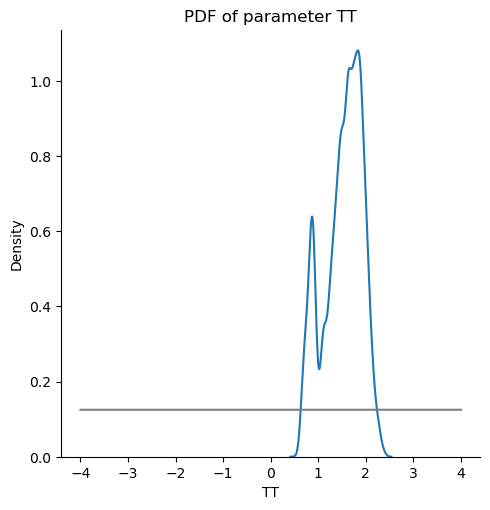

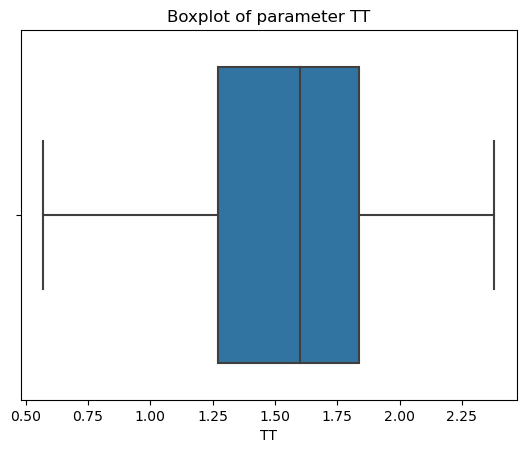

In [5]:
# Plot TT
displot(0, samples)
boxplot(0, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



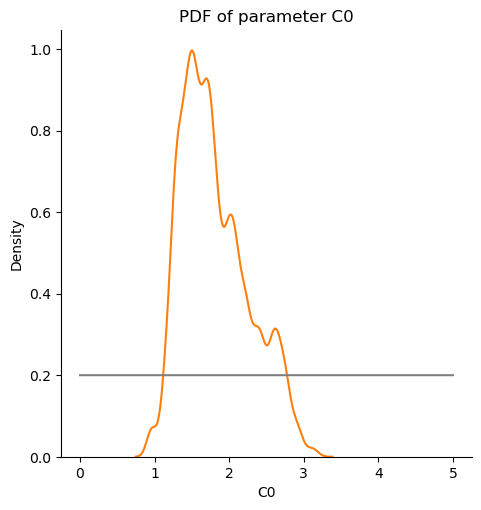

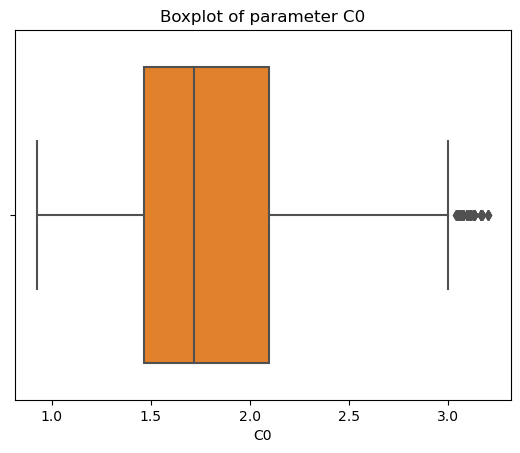

In [6]:
# Plot TT
displot(1, samples)
boxplot(1, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



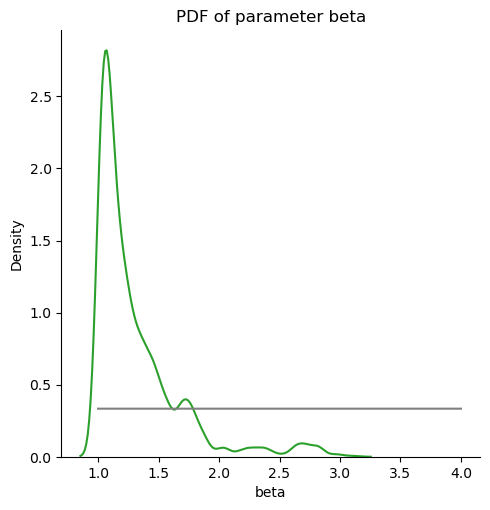

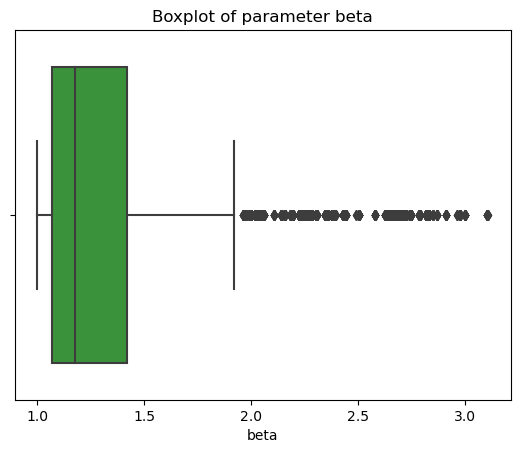

In [7]:
# Plot TT
displot(2, samples)
boxplot(2, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



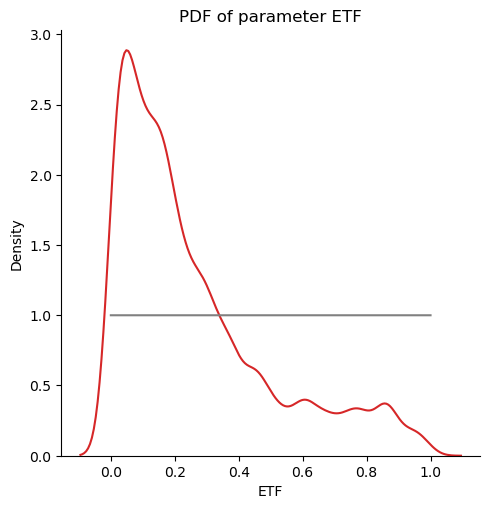

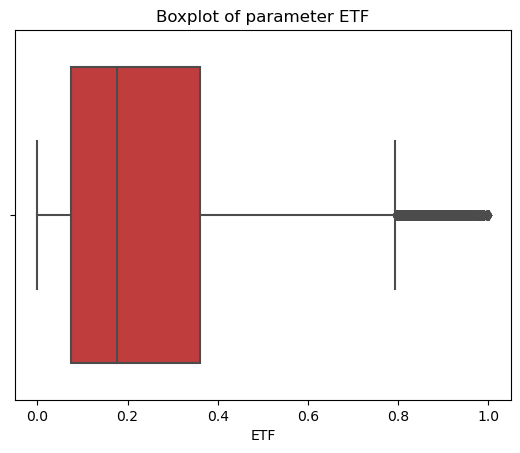

In [8]:
displot(3, samples)
boxplot(3, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



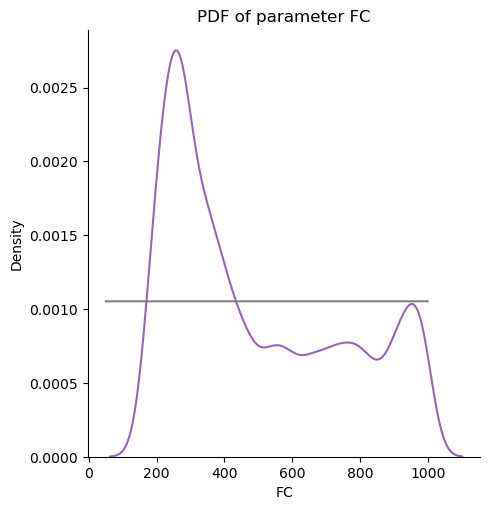

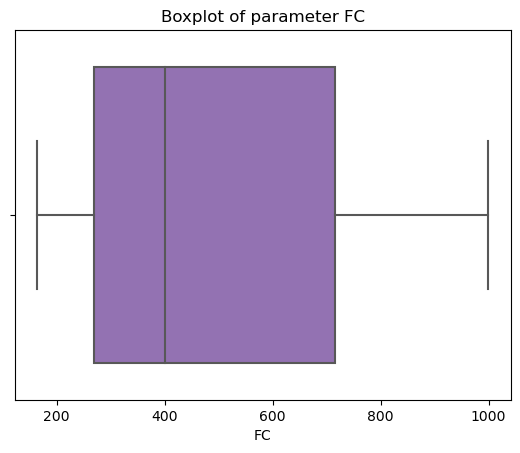

In [9]:
displot(4, samples)
boxplot(4, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



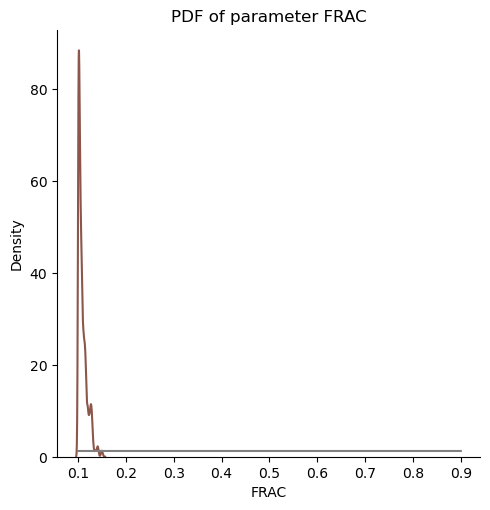

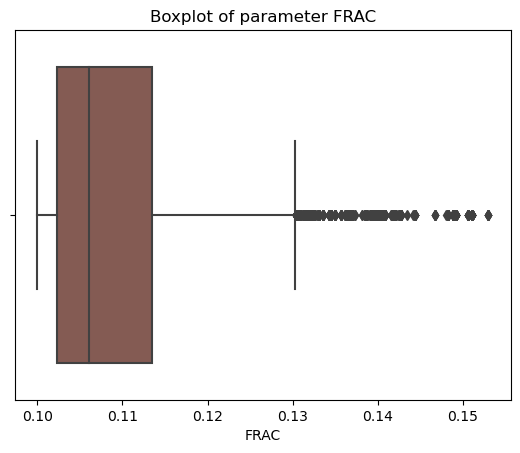

In [10]:
displot(5, samples)
boxplot(5, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



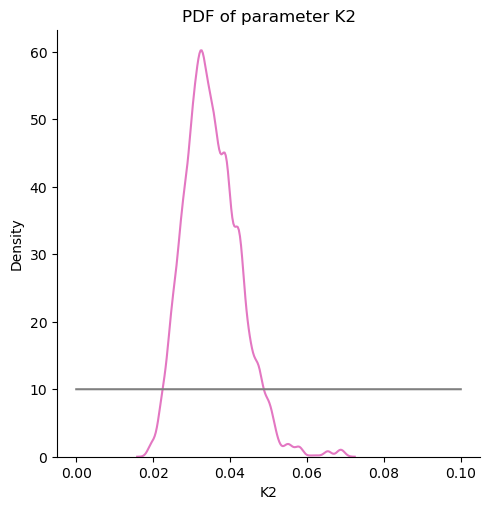

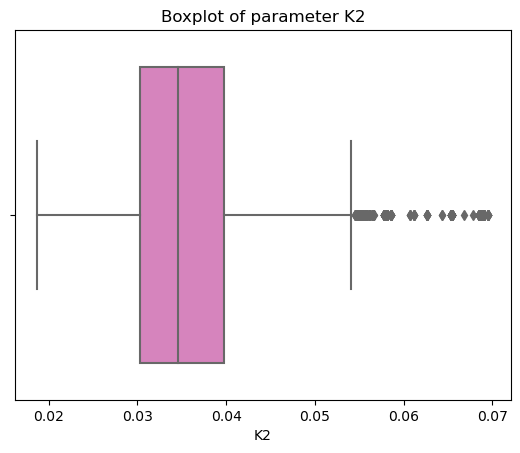

In [11]:
displot(6, samples)
boxplot(6, samples)

# Sampling

In [12]:
# Sampling Max
param_vec = []
for i in range(len(samples.loc[0])):
    values, counts = np.unique(samples.iloc[:, i], return_counts=True)
    ind = np.argmax(counts)
    param_vec.append(values[ind])

_, sampled_max, _, _ = run_model_single_parameter_node(model, param_vec)
    

[HVBSASK INFO] [0] parameters: [[1.6226777368641547, 1.5635343943388555, 1.4512785525348075, 0.039812386654615034, 343.9879284060525, 0.10404607581169129, 0.033478349157834986]]


In [13]:
# Mean Sampling from MCMC
sample_param = []
for i in range(7):
    sample_param.append(np.random.choice(samples.iloc[:, i], 1000))
sample_param = np.array(sample_param).T

all_results = []
for _, vec in enumerate(sample_param):
    _, y_model, _, _ = run_model_single_parameter_node(model, np.array(vec))
    all_results.append(y_model)

sampled_column_means = np.mean(np.array(all_results), axis=0) 


[HVBSASK INFO] [0] parameters: [array([7.95664385e-01, 1.33702508e+00, 1.33957366e+00, 6.01182867e-02,
       3.16752385e+02, 1.02740323e-01, 3.10082448e-02])]
[HVBSASK INFO] [0] parameters: [array([1.52837158e+00, 1.42940072e+00, 1.48374103e+00, 2.23971954e-01,
       3.35578131e+02, 1.07637147e-01, 3.21202788e-02])]
[HVBSASK INFO] [0] parameters: [array([1.68939877e+00, 2.57609162e+00, 1.09622201e+00, 6.19897852e-01,
       5.59520291e+02, 1.01499272e-01, 3.80888569e-02])]
[HVBSASK INFO] [0] parameters: [array([1.70472610e+00, 1.60009568e+00, 1.43596622e+00, 2.72101743e-01,
       7.70969706e+02, 1.13229717e-01, 2.31692728e-02])]
[HVBSASK INFO] [0] parameters: [array([1.20785947e+00, 1.41512583e+00, 1.21154106e+00, 6.83187898e-01,
       2.26037224e+02, 1.00840461e-01, 3.06366141e-02])]
[HVBSASK INFO] [0] parameters: [array([1.86654340e+00, 3.09975566e+00, 1.14888347e+00, 2.16568631e-02,
       8.14473111e+02, 1.08140183e-01, 3.85132237e-02])]
[HVBSASK INFO] [0] parameters: [array([1

In [14]:
# Mean Sampling from Start
sample_param = []
for i in range(7):
    #uni = uniform.rvs(loc=param_lower[i], scale=param_upper[i] - param_lower[i], size=1000)
    uni = tfp.distributions.Uniform(low=param_lower[i], high=param_upper[i]).sample(1)
    sample_param.append(uni)
sample_param = np.array(sample_param).T

all_results = []
for _, vec in enumerate(sample_param):
    _, y_model, _, _ = run_model_single_parameter_node(model, np.array(vec))
    all_results.append(y_model)

start_column_means = np.mean(np.array(all_results), axis=0)
    

[HVBSASK INFO] [0] parameters: [array([-3.16597561e-01,  3.98865122e-04,  3.36397142e+00,  4.04737981e-01,
        3.66523921e+02,  3.56969542e-01,  5.88193062e-02])]


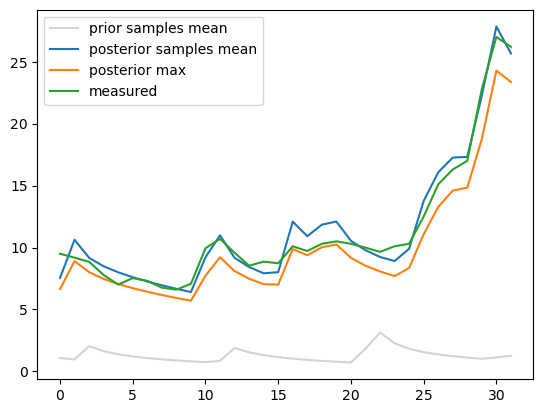

In [15]:
fig = plt.figure()
plt.plot(start_column_means, label='prior samples mean', color='lightgrey')
plt.plot(sampled_column_means, label='posterior samples mean')
plt.plot(sampled_max, label='posterior max')
plt.plot(measured_data, label='measured')
plt.legend()
plt.show()